In [1]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt


## Implementation

In [10]:
class ReLU:
    def Forward_prop(self, Z):
      self.Z = Z
      self.A = np.maximum(0,Z)
      return np.maximum(0, Z)

    def Backward_prop(self, dA):
      return dA*(self.A > 0)

class Sigmoid:
    def Forward_prop(self, Z):
        self.A = 1 / (1 + np.exp(-Z))
        return self.A

    def Backward_prop(self, dA):
        return dA * (self.A * (1 - self.A))


class Softmax:
    def Forward_prop(self, Z):
        exp = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return exp / np.sum(exp, axis=1, keepdims=True)


class Neural_Net:
  def __init__(self,layers_dim,activations):
    # layers_dims: a list of the number of neurones of the corresponding layer (including the number of features of the dataset(as the first value))
    # activations: a list contaning the name of the activation function

    self.L = len(layers_dim) - 1
    self.activations = activations
    self.parameters = {}  # a dictionnary containing the weight and the bias

    for l in range(1, self.L + 1):  #from the first layer to the last one
      self.parameters[f"W{l}"] = (np.random.rand(layers_dim[l-1],layers_dim[l])) * (np.sqrt(2 / layers_dim[l-1])) #the size of the weight matrix of the l-layer is the nb of neurone in the previous layer * the nb of neurone in the current one
      self.parameters[f"b{l}"] = np.zeros((1,layers_dim[l])) #the size of the bias matrix is 1 * the number of neurone in the current layer

  def Forward_prop(self, X):
    self.memory = {"A0": X}
    A = X

    for l in range(1, self.L + 1):  #loop on the number of layer
      W = self.parameters[f"W{l}"]
      b = self.parameters[f"b{l}"]

      #print(f"\n---- Layer {l} ----")
      #print("A shape:", A.shape)
      #print("W shape:", W.shape)
      #print("b shape:", b.shape)


      Z = A @ W + b
      if l < self.L:
      # Hidden layer → activation
        A = self.activations[l-1].Forward_prop(Z)
      else:
      # Output layer → softmax
        A = Softmax().Forward_prop(Z)

      self.memory[f"Z{l}"] = Z
      self.memory[f"A{l}"] = A

    return A

  def Backward_prop(self,X,y,lr):
    n = X.shape[0]
    grads = {}

    A_last =self.memory[f"A{self.L}"]
    dZ = (A_last - compute_y_onehot(y,len(np.unique(y))))/n   #grad of the softmax function
    n_classes = A_last.shape[0]

    for l in reversed(range(1,self.L +1)):  #we compute the gradient backward
        A_prev = self.memory[f"A{l-1}"]
        W = self.parameters[f"W{l}"]

        grads[f"W{l}"] = A_prev.T @ dZ                       #compute and store the grad with respect to W[l]
        grads[f"b{l}"] = np.sum(dZ, axis=0, keepdims=True)   #compute and store the grad with respect to b[l]

        self.parameters[f"W{l}"] -= lr*grads[f"W{l}"]    #Update the weight
        self.parameters[f"b{l}"] -= lr*grads[f"b{l}"]    #Update the bias

        if l > 1:
          dA_prev = dZ @ W.T
          dZ = self.activations[l-2].Backward_prop(dA_prev)  # l-2 and not l-1 because of the gap explain above

  def train(self,X,y,lr,n_iters):
    X = np.array(X)
    y = np.array(y)

    n = len(y)
    losses = []
    y_oh = compute_y_onehot(y,len(np.unique(y)))

    for iter in range(n_iters):
      y_preds = self.Forward_prop(X)     #compute and store all the value in the forward prop
      loss = -np.mean(np.sum(y_oh * np.log(y_preds + 1e-10), axis=1))
      losses.append(loss)
      self.Backward_prop(X,y,lr)
      #print(loss)  #update the weight and bias
    return losses
  def predict(self,X):
    X = np.array(X)
    A_last = self.Forward_prop(X)
    return np.argmax(A_last,axis=1)   #return a list containing the class that has the highest prob for every sample



def compute_y_onehot(y,n_classes):             #instead of having the class (0 or 1 or 2) for every row, create a list of list where the class is the index of the 1
  y = np.array(y)
  y_onehot = np.zeros((len(y),n_classes))    #in this sublist (all the other term are set to 0)
  for k in range(len(y)):
    y_onehot[k][y[k]] = 1
  return y_onehot

def split_data(df,target_name): # take the whole df and target's name and return the split data in an adapted form for the gradient_descent function
  df=copy.deepcopy(df)

  train, val, test = np.split(df.sample(frac=1),[int(0.6*len(df)),int(0.8*len(df))]) #split at 0.6 of the df lenght and 0.8 of the df lenght

  df_1=train.drop([target_name],axis=1)
  X_train = df_1.values.tolist()         #list of list of the features for train
  y_train = train[target_name].tolist()   #list of target for train

  df_2=val.drop([target_name],axis=1)
  X_val = df_2.values.tolist()          #list of list of the features for val
  y_val = val[target_name].tolist()    #list of target for val

  df_3=test.drop([target_name],axis=1)
  X_test = df_3.values.tolist()          #list of list of the features for test
  y_test = test[target_name].tolist()    #list of target for test

  return X_train,y_train,X_val,y_val,X_test,y_test

def scale_features(X):    #normalize features
    X = np.array(X)
    means = X.mean(axis=0)
    stds = X.std(axis=0)
    return (X - means) / stds, means, stds  #return the normalized dataset, the mean and the variance to normalize the test set with the same parameters

def accuracy(y,y_preds):
  return np.mean(y == y_preds)


##Data

In [11]:
df_train = pd.read_csv("pendigits.tra",sep=",")
df_train.head()

,attribut1,attribut2,attribut3,attribut4,attribut5,attribut6,attribut7,attribut8,attribut9,attribut10,attribut11,attribut12,attribut13,attribut14,attribut15,attribut16,class
0,47,100,27,81,57,37,26,0,0,23,56,53,100,90,40,98,8
1,0,89,27,100,42,75,29,45,15,15,37,0,69,2,100,6,2
2,0,57,31,68,72,90,100,100,76,75,50,51,28,25,16,0,1
3,0,100,7,92,5,68,19,45,86,34,100,45,74,23,67,0,4
4,0,67,49,83,100,100,81,80,60,60,40,40,33,20,47,0,1


In [13]:
X_train = df_train.drop(["class"],axis=1)
#X_train.head()
y_train = df_train["class"]
#y_train.head()
print(len(y_train))

X_train,means,stds = scale_features(X_train)

7494


In [14]:
df_test = pd.read_csv("pendigits.tes",sep=",")
df_test.head()

,attribut1,attribut2,attribut3,attribut4,attribut5,attribut6,attribut7,attribut8,attribut9,attribut10,attribut11,attribut12,attribut13,attribut14,attribut15,attribut16,class
0,88,92,2,99,16,66,94,37,70,0,0,24,42,65,100,100,8
1,80,100,18,98,60,66,100,29,42,0,0,23,42,61,56,98,8
2,0,94,9,57,20,19,7,0,20,36,70,68,100,100,18,92,8
3,95,82,71,100,27,77,77,73,100,80,93,42,56,13,0,0,9
4,68,100,6,88,47,75,87,82,85,56,100,29,75,6,0,0,9


In [15]:
X_test = df_test.drop(["class"],axis=1)
#X_train.head()
y_test = df_test["class"]
#y_train.head()
X_test = (X_test - means)/stds
X_test.head()


,attribut1,attribut2,attribut3,attribut4,attribut5,attribut6,attribut7,attribut8,attribut9,attribut10,attribut11,attribut12,attribut13,attribut14,attribut15,attribut16
0,1.519087,0.434530,-1.447597,0.820404,-0.998667,0.034906,1.386274,-0.247890,0.382148,-1.240765,-1.654194,-0.428533,-0.561979,0.878928,1.280702,1.994895
1,1.278990,0.909384,-0.838172,0.769480,0.261181,0.034906,1.581854,-0.508838,-0.449253,-1.240765,-1.654194,-0.464905,-0.561979,0.758524,0.221202,1.939043
2,-1.121985,0.553243,-1.180974,-1.318386,-0.884135,-1.681957,-1.449632,-1.454775,-1.102496,0.070321,0.231161,1.171816,2.004589,1.932466,-0.693821,1.771486
3,1.729173,-0.159037,1.180547,0.871327,-0.683705,0.436725,0.832132,0.926376,1.272935,1.672759,0.850634,0.226155,0.057537,-0.686328,-1.127253,-0.797722
4,0.918844,0.909384,-1.295241,0.260244,-0.111047,0.363667,1.158098,1.219943,0.827542,0.798702,1.039170,-0.246675,0.898309,-0.897036,-1.127253,-0.797722


In [16]:
X_train,X_test,y_train,y_test = np.array(X_train),np.array(X_test),np.array(y_train),np.array(y_test),

##Result

In [17]:
print(X_train.shape)
print(len(X_train), len(y_train))


(7494, 16)
7494 7494


In [18]:
layers_dim = [16, 32, 16, len(np.unique(y_train))]
#print(np.unique(y_train))
activations = [ReLU(),ReLU()]
model = Neural_Net(layers_dim,activations)
losses = model.train(X_train,y_train,0.05,3500)
#print(losses)

[np.float64(0.05368210666105349), np.float64(0.05369462912134713), np.float64(0.05370717502898684), np.float64(0.053719741958444596), np.float64(0.053732307724069145), np.float64(0.053744870627210985), np.float64(0.053757441769039016), np.float64(0.05377002256308424), np.float64(0.05378261199436942), np.float64(0.0537952071297963), np.float64(0.053807810912635895), np.float64(0.0538204207808513), np.float64(0.053833037195702274), np.float64(0.05384565712009217), np.float64(0.05385827278164393), np.float64(0.053870883319315915), np.float64(0.053883499252081864), np.float64(0.05389612118329213), np.float64(0.053908751864678764), np.float64(0.05392138984058861), np.float64(0.05393402883651214), np.float64(0.0539466802907265), np.float64(0.05395934139132818), np.float64(0.05397200430493111), np.float64(0.05398467030626719), np.float64(0.0539973473862288), np.float64(0.05401003122539114), np.float64(0.05402271658679755), np.float64(0.05403540645945145), np.float64(0.054048101270755065), np.

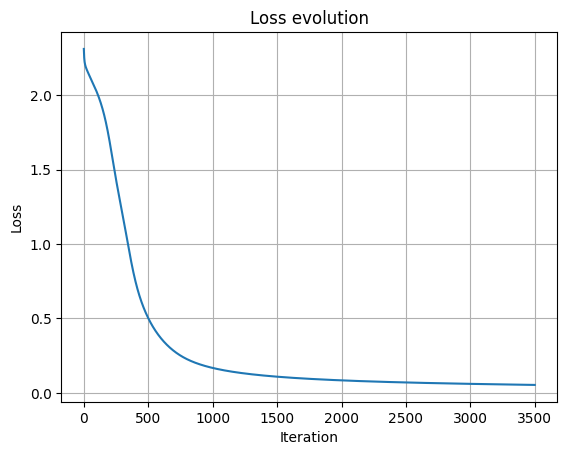

In [19]:
losses_1 = losses[::-1]
print(losses_1)
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss evolution")
plt.grid(True)
plt.show()

In [20]:
y_preds = model.predict(X_test)
acc = np.mean(y_preds == y_test)
print("Test accuracy:", acc)
losses[:10]

Test accuracy: 0.9528301886792453


[np.float64(2.3108396513203022),
 np.float64(2.2853436580734097),
 np.float64(2.266025496530438),
 np.float64(2.2513250081747773),
 np.float64(2.240027321934827),
 np.float64(2.2311817468126076),
 np.float64(2.2240779743830332),
 np.float64(2.218209089162533),
 np.float64(2.213222685592054),
 np.float64(2.208877605899986)]

In [21]:
layers_dim = [16, 32, 32, len(np.unique(y_train))]
#print(np.unique(y_train))
activations = [ReLU(),ReLU()]
model = Neural_Net(layers_dim,activations)
losses = model.train(X_train,y_train,0.05,3500)
#print(losses)

[np.float64(0.044031305718297956), np.float64(0.04404093739130131), np.float64(0.04405056570532912), np.float64(0.04406020124105351), np.float64(0.04406983555239426), np.float64(0.04407947701762728), np.float64(0.04408912384419816), np.float64(0.044098788229314734), np.float64(0.044108453195242515), np.float64(0.04411812080391523), np.float64(0.04412780927975946), np.float64(0.04413748661545534), np.float64(0.044147173581832996), np.float64(0.044156870587097295), np.float64(0.04416657369789684), np.float64(0.04417628784906753), np.float64(0.04418600720913798), np.float64(0.044195739088802505), np.float64(0.04420546404226121), np.float64(0.044215203856776006), np.float64(0.044224952765888656), np.float64(0.04423469262488043), np.float64(0.04424445960508014), np.float64(0.044254248160762726), np.float64(0.04426406760939458), np.float64(0.04427390994436709), np.float64(0.044283750457583135), np.float64(0.04429359191224149), np.float64(0.04430344991863298), np.float64(0.044313311017880885)

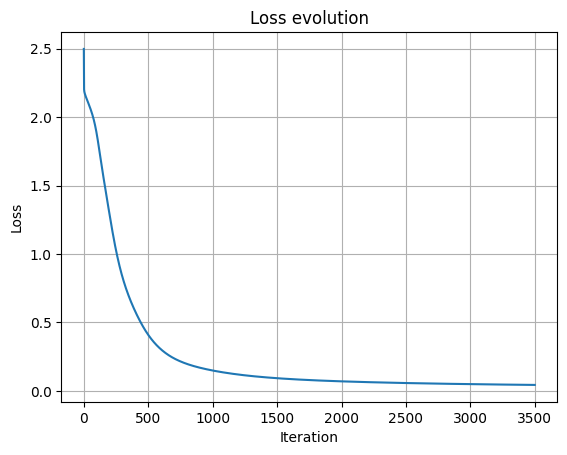

In [22]:
losses_1 = losses[::-1]
print(losses_1)
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss evolution")
plt.grid(True)
plt.show()

In [23]:
y_preds = model.predict(X_test)
acc = np.mean(y_preds == y_test)
print("Test accuracy:", acc)
losses[:10]

Test accuracy: 0.9602630074328188


[np.float64(2.4980404352261347),
 np.float64(2.265141232510245),
 np.float64(2.202612046543777),
 np.float64(2.191566922341114),
 np.float64(2.1856058055601983),
 np.float64(2.181104590041167),
 np.float64(2.1772213201828987),
 np.float64(2.173695178078907),
 np.float64(2.17040932081988),
 np.float64(2.1672982905190867)]